In [23]:
#libraries
import thesisFunctions
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
import seaborn as sns
from scipy.stats import normaltest
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16.0, 12.0)

%matplotlib inline

# Introduccion

El proposito de este trabajo es actualizar el indice CAPECO creado por el INDEC, con datos del censo de 2001, con los datos del censo 2010. El modelo subyacente utiliza las siguientes variables para aproximarse al ingreso individual de las personas:

* Años de escolaridad primaria (*primary*)
* Años de escolaridad secundaria (*secondary*)
* Años de escolaridad universitaria (*university*)
* Varón entre 14 y 24 años (*male_14to24*)
* Varón entre 25 y 34 años (*male_25to34*)
* Mujer entre 14 y 24 años (*female_14to24*)
* Mujer entre 25 y 34 años (*female_25to34*)
* Mujer entre de 35 años o más (*female_35more*)

El modelo original incluye la región a la que pertenece la persona (los ingresos varían según la región del país) y si la persona percibía jubilación o pensión. Sin embargo en este trabajo únicamente analizamos el modelo para la región del Aglomerado Gran Buenos Aires y en el censo 2010 no se preguntó en el formulario básico sobre la percepción de jubilación o pensión.

# El modelo
Creamos una tabla de datos con los registros personales de la EPH para el tercer trimestre de 2010, las varibables de interés en la especificación requerida por el modelo y el ponderador. Uno de los requerimientos del modelo es trabajar con el logaritmo del ingreso. Esta variable será nuestra regresor.

In [24]:
ind3t10 = pd.read_csv('../dt/t310/ind3t10.csv') 
ind3t10.head()

,CODUSU,NRO_HOGAR,COMPONENTE,AGLOMERADO,PONDERA,familyRelation,female,age,schoolLevel,finishedYear,...,male_25to34,female_14to24,female_25to34,female_35more,education,education2,age2,id,lnIncome,lnIncomeT
0,302468,1,1,32,1287,1,1,20,7.0,2,...,0,1,0,0,13.0,169.0,400,3024681,0.000000,7.600902
1,302468,1,2,32,1287,10,1,20,6.0,2,...,0,1,0,0,13.0,169.0,400,3024681,0.000000,7.600902
2,307861,1,1,32,1674,1,0,42,2.0,1,...,0,0,0,0,7.0,49.0,1764,3078611,8.006368,8.006368
3,307861,1,2,32,1674,2,1,44,7.0,1,...,0,0,0,1,17.0,289.0,1936,3078611,7.937375,7.937375
4,307861,1,3,32,1674,3,0,13,4.0,2,...,0,0,0,0,7.0,49.0,169,3078611,0.000000,0.000000


In [27]:
ind3t10.lnIncome = ind3t10.lnIncomeT

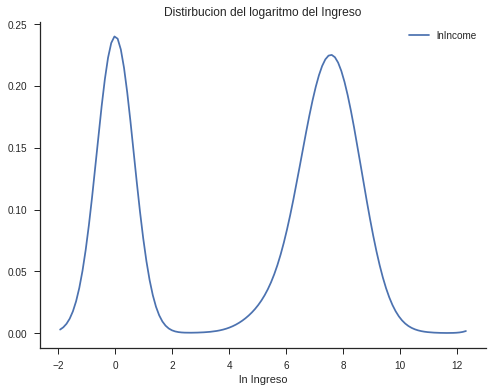

In [28]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
sns.kdeplot(data=ind3t10.lnIncome, ax=ax)    
sns.despine()
plt.title('Distirbucion del logaritmo del Ingreso')
plt.xlabel('ln Ingreso')
#plt.xlabel('Educacion')
#plt.ylabel('ln Ingreso')

Numerosos casos registran nulos ingresos 0 y/o actualmente no tienen trabajo. Este modelo basado en el paradigma de capital humano, se sustenta en los retornos que el mercado de trabajo ofrece a la inversión en educación por parte de los individuos. De modo que, solo puede dar cuenta de los ingresos laborales de aquellos que tienen trabajo. Esto implica una limitación a la hora de percibir el conjunto de los ingresos (de los cuales los laborales, si bien una parte importante, constituyen solo una porción). Al mismo tiempo, las personas con trabajo que no perciben ingresos y tienen trabajo constituyen un caso extremo que perjudica la performance del modelo. Puede deberse a que el trabajo es reciente y aún no cobraron el primer salario.

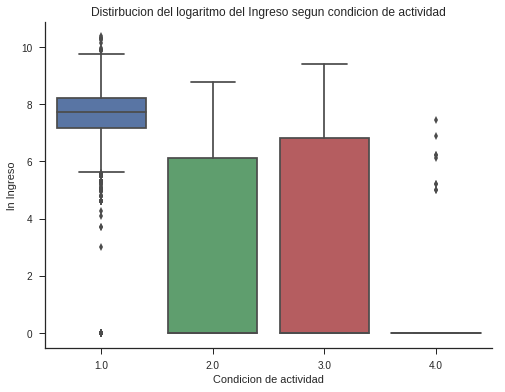

In [29]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
sns.boxplot(x="activity", y="lnIncome", data=ind3t10)
sns.despine()
plt.title('Distirbucion del logaritmo del Ingreso segun condicion de actividad')
plt.xlabel('Condicion de actividad')
plt.ylabel('ln Ingreso')

Por ello, eliminamos del set de datos que utilizaremos para el modelo a aquellos que no perciben ningun tipo de ingreso o que no se encuentran trabajando.

In [30]:
jobsAndIncome = ((ind3t10.activity==1) & (ind3t10.lnIncome>1))
ind3t10Model = ind3t10.copy().loc[jobsAndIncome,:]

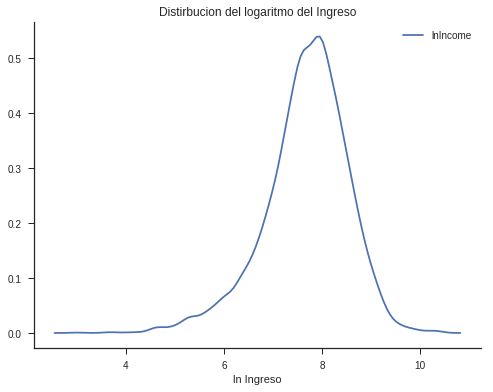

In [31]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
sns.kdeplot(ind3t10Model.lnIncome)
sns.despine()
plt.title('Distirbucion del logaritmo del Ingreso')
plt.xlabel('ln Ingreso')

La distirbución de la variable se asemeja a una distribución normal, con p-value menor a 5%. Esto mejora la performance del modelo.

In [32]:
normaltest(ind3t10Model.lnIncome)

NormaltestResult(statistic=361.493373754348, pvalue=3.1820812675358858e-79)

Siendo las dos variable fundamentales de este modelo la edad, los años de escolaridad y el género, podemos explorar como se comportan estas variables en relación al logaritmo del ingreso. Dado que la EPH utiliza ponderadores, los resultados visuales pueden ser algo engañosos en la medida en que cada punto no representa igual cantidad de casos. 

In [33]:
dataMasc = ind3t10Model.loc[ind3t10Model.female==0,:]
dataFem = ind3t10Model.loc[ind3t10Model.female==1,:]

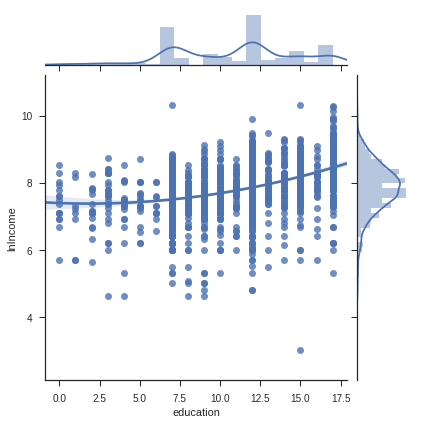

In [34]:
g = sns.JointGrid(x="education", y="lnIncome", data=dataMasc)  
g.plot_joint(sns.regplot,order=2)
g.plot_marginals(sns.distplot)


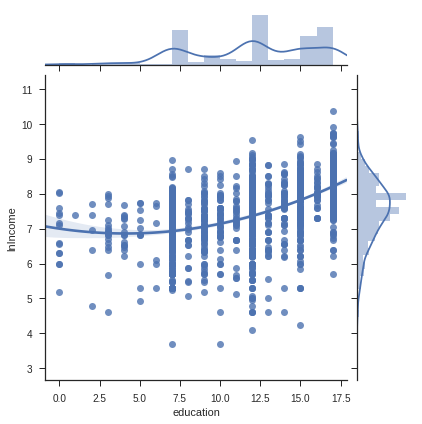

In [35]:
g = sns.JointGrid(x="education", y="lnIncome", data = dataFem)  
g.plot_joint(sns.regplot, order=2)  
g.plot_marginals(sns.distplot)


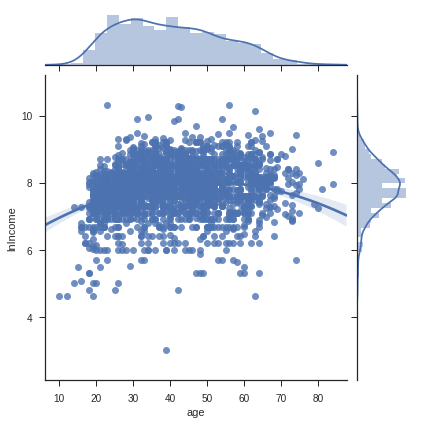

In [36]:
g2 = sns.JointGrid(x="age", y="lnIncome", data=dataMasc)  
g2.plot_joint(sns.regplot, order=2)  
g2.plot_marginals(sns.distplot)

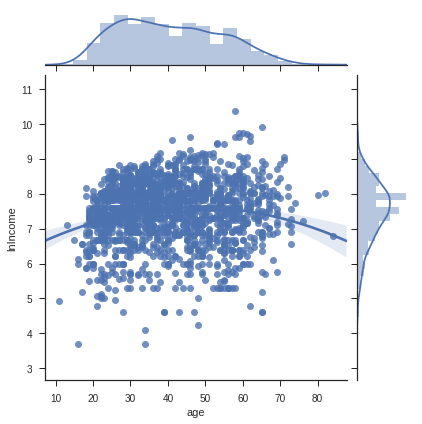

In [37]:
g2 = sns.JointGrid(x="age", y="lnIncome", data=dataFem)  
g2.plot_joint(sns.regplot, order=2)  
g2.plot_marginals(sns.distplot)

El comportamiento de la variable es similar (a pesar de una media de ingreso superior en los hombres). A mayor escolarización mayor salario. Pero esta relación no es lineal, sino que cada año de escolaridad de los tramos superiores ofrece mayores retornos que cada año de los tramos inferiores de escolaridad. Así por ejemplo un año adicional de universidad incrementa más el salario que un año adicional de primaria.

En lo que corresponde a la edad, parece haber una relación creciente hasta pasados los 30 años. Llegada esa edad hay un amesetamiento por el cual no hay incrementos salariales a partir de la edad, para luego comenzar un proceso descendente (el año que inicia el cambio de tendencia hacia el descenso cambia de acuerdo al género: en las mujeres este proceso parece ser durante los 50s mientras que en los hombres en los 60s, lo que coincide con las diferencias en las edades jubilatorias legales).

# El modelo individual

A continuación procedemos a correr el modelo para todos los individuos con ingresos y que se encuentren empleados. La performance del mismo es disimil. Si bien por un lado todos los parametros son estadisticamente significativos para cualquier nivel de confianza, el modelo en su ocnjunto alcanza un R2 de solo 27%. Esto quiere decir que este modelo solo puede dar cuenta del 27% de la variabilidad del logaritmo del ingreso. De todos modos es importante recordar que este modelo no considera elementos fundamentales para el ingreso como la cantidad de horas trabajadas o la rama en la que se desempeña cada persona. Diferentes ramas tienen diferentes productividades y por lo tanto pagan diferentes salarios. 

De todos modos, el objetivo último de este modelo es ofrecer fundamento para los coeficientes del CAPECO. En todo caso veremos al final que capacidad tiene el CAPECO para dar cuenta de la variabilidad del ingreso. 

En primer lugar, el intercepto da cuenta del ingreso esperado para un hombre adulto de 35 años o más con 0 años de escolaridad en cualquiera de los 3 niveles. Este constituye el caso base o registro con el cual compararemos al resto de los casos.

En segundo lugar los coeficientes dan cuenta de una relación Log-Nivel, esto quiere decir, por tomar el ejemplo del primer coeficiente (años de escolaridad primaria), que un año de escolaridad primaria ofrece un incremento de 7.87% en el ingreso. Dicho de otro modo, un hombre adulto de 35 años o más con 1 año de escolaridad, gana un 7.87% más que nuestro caso base (un hombre adulto de 35 años o más con 0 años de escolaridad). Del mismo modo, un año de escolaridad secundaria ofrece un incremento de 8.38% y un año de escolaridad superior ofrece 12.21%. Como es de esperar, los rendimientos no son lineales. Esto quiere decir que en el mercado laboral se valorizan más los años de escolaridad secundaria que los de primaria y los de educación superior a los de secundaria. El supuetso subyacente es que la productividad del trabajo aumenta con la capacitación que ofrece el sistema educativo.

En tercer lugar, los parámetros vinculados a la edad para los hombres, actúan como penalidades. Es decir, se supone que la edad conlleva experiencia y con ella mayor productividad. A su vez, el ciclo vital conlleva que los gastos de personas de tramos etarios superiores sean mayores. Es por ello que los hombres entre 14 y 24 años de edad sin años de escolaridad, ganarán un 42,12% menos que el caso base, manteniendo todas las otras variables consideradas en el modelo constantes. A su vez, un hombre entre 25 y 34 años sin años de escolaridad tendrá un ingreso 15,47% menor al del caso registro.    

Finalmente, es necesario tomar en consideración el efecto del género conjugado con la edad. En primer lugar, parámetro que da cuenta del efecto del género al comparar una mujer de 35 años o más sin años de escolaridad con nuestro caso base (un hombre de idénticas características), nos dice que dicha mujer tendría un ingreso 58.43% menor. Para los otros tramos de edades, una mujer entre 14 y 24 años dicha diferencia es de un 92.96 % menos y entre 25 y 34 años es de 62.64% menos. 

# PEOR R

In [38]:
model = thesisFunctions.runModel(ind3t10Model, income = 'lnIncome', variables= [
        'primary','secondary','university',
        'male_14to24','male_25to34',
        'female_14to24', 'female_25to34', 'female_35more'])

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.269
Model:                            WLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     168.1
Date:                Fri, 14 Jul 2017   Prob (F-statistic):          4.76e-242
Time:                        14:12:08   Log-Likelihood:                -4060.3
No. Observations:                3657   AIC:                             8139.
Df Residuals:                    3648   BIC:                             8194.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          7.2134      0.090     79.910      0.0

## Evaluacion de la regresion

In [39]:
variables= [
        'primary','secondary','university',
        'male_14to24','male_25to34',
        'female_14to24', 'female_25to34', 'female_35more']
    
X = sm.add_constant(ind3t10Model.copy().loc[:,variables].values)
ind3t10Model['predicted'] = model.predict(X)

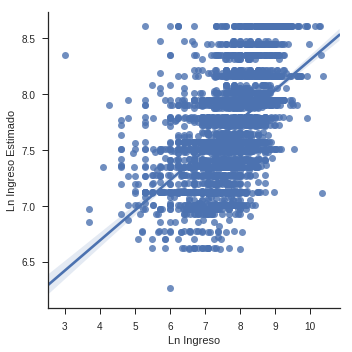

In [40]:
sns.lmplot(x = 'lnIncome', y ='predicted',data=ind3t10Model)
plt.xlabel('Ln Ingreso')
plt.ylabel('Ln Ingreso Estimado')

el ln del ingreso y los residuos tienne una relacion lineal

In [41]:
from statsmodels.graphics.gofplots import qqplot

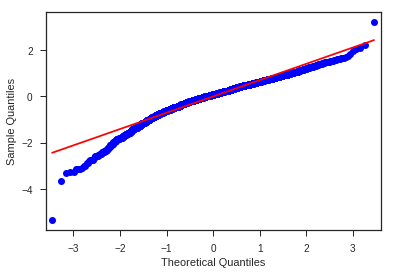

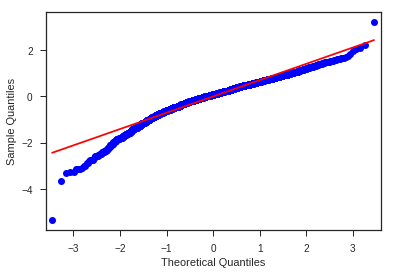

In [42]:
#https://www.coursera.org/learn/regression-modeling-practice/lecture/q2xna/python-lesson-4-evaluating-model-fit-pt-1
qqplot(model.resid,line='r')

Este grafico muestra que los residuos no estan perfectamente distribuidos segun la normal

In [43]:
ind3t10Model['resid'] = ind3t10Model.lnIncome - ind3t10Model.predicted 
print 'media ponderada de los residuos:%.4f'%np.average(ind3t10Model.resid, weights=ind3t10Model.PONDERA)


media ponderada de los residuos:-0.0074


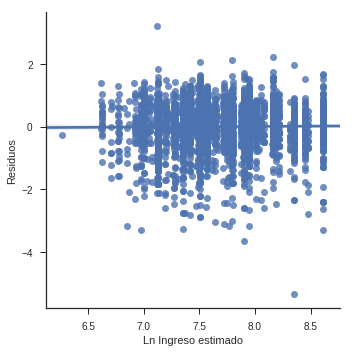

In [44]:
sns.lmplot(x = 'predicted', y ='resid',data=ind3t10Model)
plt.ylabel('Residuos')
plt.xlabel('Ln Ingreso estimado')

In [45]:
ind3t10Model['residStd'] = (ind3t10Model.resid - ind3t10Model.resid.mean()) / ind3t10Model.resid.std()

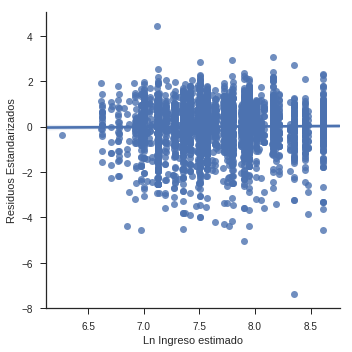

In [46]:
sns.lmplot(x = 'predicted', y ='residStd',data=ind3t10Model)
plt.ylabel('Residuos Estandarizados')
plt.xlabel('Ln Ingreso estimado')

Como se puede observar, los residuos se mueven mayoritariamente dentro de la franja de los 2 desvíos estándar, con algunos casos moviendose entre los 2 y 3 desvíos estándar per debajo de la media, indicando una sobreestimacion en nuestro modelo 